In [1]:
import torch
from sklearn.preprocessing import MinMaxScaler
from ultralytics import YOLO
from transformers import DPTImageProcessor, DPTForDepthEstimation, pipeline

import gc

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


/root/miniconda3/envs/ipynb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pipe_dpt = pipeline(task="depth-estimation", model="Intel/dpt-large")
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large", cache_dir="model")
estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-large", cache_dir="model").to("cuda:0")

/root/miniconda3/envs/ipynb/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
img1 = cv2.imread("/home/akiirabino/video-anal/ipynb/dataset-1/image.png")
img2 = cv2.imread("/home/akiirabino/video-anal/ipynb/dataset-1/image2.png")
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

In [25]:
from skimage.metrics import structural_similarity
structural_similarity(img1, img2, channel_axis=2)

0.35539798540071194

In [5]:
inputs = processor(images=img1, return_tensors="pt")
inputs.to("cuda:0")

with torch.no_grad():
    outputs1 = estimator(**inputs)
    predicted_depth = outputs1.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img1.shape[1::-1],
    mode="bicubic",
    align_corners=False,
)
output1 = prediction.squeeze().cpu().numpy()
scaler = MinMaxScaler((0, 640))
output = scaler.fit_transform(output1)
output1.shape

(640, 640)

In [6]:
model = YOLO("model/yolov8l-d3-e100-default-best.pt")
result_yolo1 = model(img1)


0: 640x640 (no detections), 156.1ms
Speed: 30.4ms preprocess, 156.1ms inference, 4099.6ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
inputs = processor(images=img1, return_tensors="pt")
inputs.to("cuda:0")

with torch.no_grad():
    outputs2 = estimator(**inputs)
    predicted_depth = outputs2.predicted_depth

prediction2 = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img1.shape[1::-1],
    mode="bicubic",
    align_corners=False,
)
output2 = prediction.squeeze().cpu().numpy()
scaler = MinMaxScaler((0, 640))
output2 = scaler.fit_transform(output1)
output2.shape

(640, 640)

In [8]:
model = YOLO("model/yolov8l-d3-e100-default-best.pt")
result_yolo2 = model(img2)


0: 640x640 (no detections), 67.1ms
Speed: 1.2ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
del processor, estimator, model

In [10]:
gc.collect()
torch.cuda.empty_cache()

In [11]:
result_yolo1[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))

In [12]:
def xyxyn2xyxy(x, y, shape):
    return x * shape[0], y * shape[1]

In [13]:
def xyxyn_yolo2xyxy_plt(x, y, w, h, shape):
    return x * shape[0] - w / 2, y * shape[1] - h / 2

In [14]:
cls1 = result_yolo1[0].boxes.cls.detach().cpu()
xywh1 = result_yolo1[0].boxes.xywh.detach().cpu()
xywhn1 = result_yolo1[0].boxes.xywhn.detach().cpu()
img_plt1 = result_yolo1[0].plot()
coordinate1 = result_yolo1[0].boxes.xywhn[0].cpu().detach()
x1,y1,w1,h1 = list(map(int, map(lambda x: x*640, coordinate1)))
x1 = int(coordinate1[0] - coordinate1[2] // 2)
x2 = int(coordinate1[0] + coordinate1[2] // 2)
y1 = int(coordinate1[1] - coordinate1[3] // 2)
y2 = int(coordinate1[1] + coordinate1[3] // 2)

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
def distance(xyz1, xyz2):
    x1, y1, z1 = xyz1
    x2, y2, z2 = xyz2
    return (
        np.sqrt(
            np.power(x1 - x2, 2) +
            np.power(y1 - y2, 2) +
            np.power(z1 - z2, 2)
        )
    )

In [ ]:
import uuid
peoples = []

for cl, n_bbox in zip(cls1, xywhn1):
    peoples.append(
        {
            "uuid": uuid.uuid4(),
            "type": "",
            "embedding": None,
            "corner_coordinates": {
                "x1": 0,
                "x2": 0,
                "y1": 0,
                "y2": 0,
            },
            "center_point": [],
            "distances": []
        }
    )

    x, y, w, h = list(map(int, map(lambda x: x*640, n_bbox)))
    
    peoples[-1]["corner_coordinates"]["x1"] = int(x - w // 2)
    peoples[-1]["corner_coordinates"]["x2"] = int(x + w // 2)
    peoples[-1]["corner_coordinates"]["y1"] = int(y - h // 2)
    peoples[-1]["corner_coordinates"]["y2"] = int(y + h // 2)

    dpt = int(output[x-1:x, y-1:y].item())
    if cl == 1: peoples[-1]["type"] = "customer"
    elif cl==0: peoples[-1]["type"] = "people"
    else: peoples[-1]["type"] = "seller"
    peoples[-1]["center_point"] = [x, y, dpt]

In [ ]:
peoples

[{'uuid': UUID('66a9b992-8c2a-4586-9867-c046010ebb0f'),
  'type': 'customer',
  'embedding': None,
  'corner_coordinates': {'x1': 300, 'x2': 408, 'y1': 138, 'y2': 286},
  'center_point': [354, 212, 421],
  'distances': []},
 {'uuid': UUID('6998892e-a896-4908-914f-11b554d8209e'),
  'type': 'seller',
  'embedding': None,
  'corner_coordinates': {'x1': 79, 'x2': 129, 'y1': 526, 'y2': 576},
  'center_point': [104, 551, 18],
  'distances': []},
 {'uuid': UUID('dba4e0d5-5a8b-40dd-a710-3be5c009c973'),
  'type': 'seller',
  'embedding': None,
  'corner_coordinates': {'x1': 72, 'x2': 118, 'y1': 615, 'y2': 639},
  'center_point': [95, 627, 0],
  'distances': []}]

In [ ]:
peoples[0]["center_point"]

[354, 212, 421]

In [ ]:



for seller in [p for p in peoples if p["type"] == "seller"]:
    for customer in [p for p in peoples if p["type"] == "customer"]:
        if seller["embedding"] is None:
            seller["embedding"] = img_plt1[
                    seller["corner_coordinates"]["y1"]:seller["corner_coordinates"]["y2"],
                    seller["corner_coordinates"]["x1"]:seller["corner_coordinates"]["x2"],
                ]
        elif customer["embedding"] is None:
            customer["embedding"] = img_plt1[
                    customer["corner_coordinates"]["y1"]:customer["corner_coordinates"]["y2"],
                    customer["corner_coordinates"]["x1"]:customer["corner_coordinates"]["x2"],
                ]
            
        d = distance(customer["center_point"], seller["center_point"])
        seller["distances"].append(
            {
                "uuid": customer["uuid"],
                "distance": d,
            }
        )

        customer["distances"].append(
            {
                "uuid": seller["uuid"],
                "distance": d,
            }
        )

In [ ]:
peoples

[{'uuid': UUID('84a059f2-6eb2-4ca0-8348-938021446d39'),
  'type': 'seller',
  'embedding': array([[[ 31, 112, 255],
          [ 31, 112, 255],
          [ 31, 112, 255],
          ...,
          [ 31, 112, 255],
          [ 31, 112, 255],
          [ 31, 112, 255]],
  
         [[ 31, 112, 255],
          [ 31, 112, 255],
          [109, 145, 224],
          ...,
          [136, 159, 211],
          [132, 156, 219],
          [104, 140, 255]],
  
         [[ 31, 112, 255],
          [ 31, 112, 255],
          [136, 158, 204],
          ...,
          [170, 177, 180],
          [165, 172, 194],
          [126, 148, 255]],
  
         ...,
  
         [[ 31, 112, 255],
          [ 31, 112, 255],
          [ 50,  68, 144],
          ...,
          [ 45,  43,  35],
          [136, 136, 150],
          [126, 148, 255]],
  
         [[ 31, 112, 255],
          [ 31, 112, 255],
          [ 64,  84, 165],
          ...,
          [ 66,  66,  80],
          [133, 134, 164],
          [126, 148,

In [ ]:
emb1 = peoples[0]["embedding"]
emb2 = peoples[2]["embedding"]
emb3 = peoples[3]["embedding"]

In [ ]:
emb1.shape

(176, 36, 3)

In [ ]:
emb2.shape

(236, 42, 3)

In [ ]:
emb3.shape

(176, 36, 3)

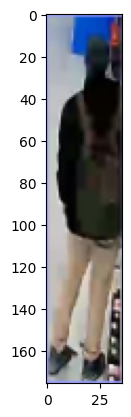

In [ ]:
plt.imshow(cv2.resize(emb2, (36, 176)))

In [ ]:
emb2 = cv2.resize(emb2, (36, 176))